In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F

In [2]:
# Set the run id and query id
run_id=181
qid=1281

In [37]:
dts = DocTopic.objects.filter(run_id=run_id).values('doc_id','doc__title','topic__title','score')
df = pd.DataFrame.from_dict(list(dts))
df_wide = df.pivot_table(index=['doc_id','doc__title'],columns='topic__title',values='score').fillna(0)

df_wide.to_csv('../data/doc_topics.csv')

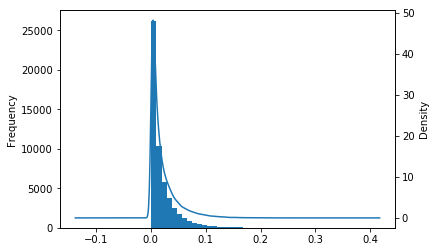

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)

df.plot.hist(ax=ax,bins=30,  legend=False)
ax1 = ax.twinx()
df.plot(kind="kde",ax=ax1, legend=False )
plt.show()

In [51]:
# Get the papers


In [ ]:
import csv

papers = Doc.objects.filter(query=qid)

with open('../data/doc_topics_compact.csv', 'w', newline='') as csvfile:
    f = csv.writer(csvfile)
    f.writerow(['paper','main topics','smaller topics'])

    for p in papers.iterator():
        main_topics = "; ".join([x.topic.title for x in p.doctopic_set.filter(run_id=run_id,score__gt=0.02).order_by('-score')])
        
        small_topics = "; ".join([x.topic.title for x in p.doctopic_set.filter(run_id=run_id,score__gt=0.01,score__lt=0.02).order_by('-score')])
        dis = p.citation()
        f.writerow([dis,main_topics,small_topics])

Effects of aggregate reuse for overpass reconstruction-extension projects on energy conservation and greenhouse gas reduction: A case study from Shanghai City
['0.0524018090338123  :  {emiss, carbon, ghg}', '0.0276011659810759  :  {energi, build, consumpt}']
